In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import cv2
from datetime import datetime
from zipfile import ZipFile
import matplotlib.pyplot as plt

import PIL.Image as Image
import pathlib
import os
import subprocess


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard

from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

: 

In [20]:
if os.path.exists("gender-classification-dataset.zip"):
    print("path exist")
    if (os.path.exists("data/Training") & os.path.exists("data/Validation")):
        print("Train and Val set has been extracted")
    else:
        with ZipFile("gender-classification-dataset.zip", "r") as zip:
            zip.extractall("data/")
        
else:
    result = subprocess.Popen("kaggle datasets download -d cashutosh/gender-classification-dataset", shell=True, stdout=subprocess.PIPE)
    print(result.communicate()[0].decode("utf-8"))

path exist
Train and Val set has been extracted


In [17]:
!kaggle datasets download -d cashutosh/gender-classification-dataset

gender-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Get directory path to Training dataset
train_dir = pathlib.Path('data/Training')
# Get a list of all images in the Training dataset
train_image_paths = list(train_dir.glob(r'**/*.jpg'))

# Get directory path to Validation dataset
valid_dir = pathlib.Path('data/Validation')
# Get a list of all images in the Validation dataset
valid_image_paths = list(valid_dir.glob(r'**/*.jpg'))

## Image Processing

In [6]:
# Create a function to extract the labels from image filepath
def image_processing(filepath):
    labels = [str(filepath[i]).split(os.path.sep)[-2]
             for i in range(len(filepath))]
    
    # Create a DataFrame and input the filepath and labels
    filepath = pd.Series(filepath, name = 'Filepath').astype(str)
    labels = pd.Series(labels, name = 'Label')
    
    df = pd.concat([filepath, labels], axis='columns')
    
    return df

In [7]:
# Create a train and validation DataFrame
train_df = image_processing(train_image_paths)
val_df = image_processing(valid_image_paths)

In [5]:
# Create DataFrame with just one label for each label
df_unique = train_df.copy().drop_duplicates(subset=['Label']).reset_index()

In [8]:
# Generate new images from dataset
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [6]:
# Generate images using 'train_df' DataFrame
train_images = train_generator.flow_from_dataframe(
    dataframe  = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 0,
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

Found 47009 validated image filenames belonging to 2 classes.


In [14]:
# Generate images using 'val_df' DataFrame
val_images = train_generator.flow_from_dataframe(
    dataframe  = val_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 0,
    rotation_range = 30,
    zoom_range = 0.15,
    save_to_dir="data/Training_transform",
    save_prefix = "val_",
    save_format="jpg",
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

Found 11649 validated image filenames belonging to 2 classes.


In [16]:
for batches in val_images:
    pass

In [4]:
# Use Tensorflow pretrained model
pretrained_model = tf.keras.applications.MobileNetV2(
input_shape= (224, 224, 3),
include_top = False,
weights = 'imagenet',
pooling = 'avg'
)

# Freeze weights
pretrained_model.trainable = True

ImportError: `load_weights` requires h5py package when loading weights from HDF5. Try installing h5py.

In [73]:
# Create weights
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation = 'relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)

outputs = tf.keras.layers.Dense(2, activation = 'softmax')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
earlystop = EarlyStopping(
            monitor = 'val_loss',
            patience = 2,
            restore_best_weights = True)  
model_names = "model/checkpoint/model.{epoch:02d}-{val_acc:.2f}.hdf5" 
checkpoint = ModelCheckpoint(model_names, monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=False)
log_file_path = "model/log.txt"
csv_logger = CSVLogger(log_file_path, append=False)
tensorboard_log_dir = "model/logs_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

In [75]:
# Train model
history = model.fit(
    train_images,
    validation_data = val_images,
    batch_size = 32,
    epochs = 100,
    callbacks = [earlystop, checkpoint, csv_logger, ]
)

Epoch 1/100
   8/1470 [..............................] - ETA: 73:54:47 - loss: 0.5011 - accuracy: 0.7578

In [ ]:
# Create labels dictionary
labels = {0: 'female',
         1: 'male'}

In [ ]:
# Create a function for image processing and prediction
def output(imagepath):
    img = image.load_img(imagepath, target_size=(224, 224, 3))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, [0])
    
    answer = model.predict(img)[0]
    
    idx = answer.argmax(axis=-1)
    res = labels[idx]
    
    return res

In [ ]:
# Predict gender
img = output('../input/gender-classification-dataset/Validation/male/063515.jpg.jpg')
img

In [ ]:
# Save model
model.save('GR.h5')

In [12]:
save_model = tf.keras.models.load_model("model/GR.h5")
save_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [65]:
test_st = tf.keras.utils.image_dataset_from_directory("data/Validation", image_size=(224, 224), shuffle=True, batch_size=110)

Found 11649 files belonging to 2 classes.


In [60]:
class_name = test_st.class_names

In [66]:
for images, labels in test_st:
    imgs = images
    lb = labels.numpy()
    break

In [67]:
predict = (save_model.predict(imgs)
           .argmax(axis=1)
           )

4/4 [==============================] - 11s 2s/step


In [50]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, plot_confusion_matrix

In [68]:
print(classification_report(lb, predict))

              precision    recall  f1-score   support

           0       0.50      0.87      0.64        54
           1       0.56      0.16      0.25        56

    accuracy                           0.51       110
   macro avg       0.53      0.52      0.44       110
weighted avg       0.53      0.51      0.44       110



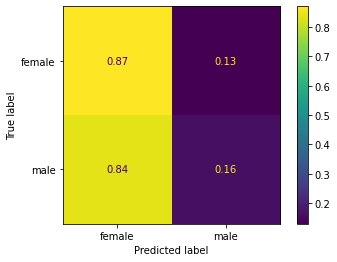

In [69]:
ConfusionMatrixDisplay.from_predictions(lb, predict, display_labels=class_name, normalize="true")

In [37]:
from keras.models import load_model
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# import numpy as np
# import cv2
# import os

In [38]:
model = load_model('model/GR.h5')

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [39]:
classes = {0: 'female', 1: 'male'}

In [6]:
webcam = cv2.VideoCapture(0)
# Loop through frames
while webcam.isOpened():
    # Read the frames from the webcam
    status, frame = webcam.read()
    
    img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Apply face detection
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(
            image = img_gray, scaleFactor = 1.1, minNeighbors = 3
        )
    
    
    # Loop through the detected faces
    for x,y,w,h in faces:
        
        # Get corners of the face rectangle
        (startX, startY) = x, y
        (endX, endY) = w, h 
        
        # Draw rectangle over face
        cv2.rectangle(frame, (startX, startY), pt2 = (x + w, y + h), color = (0, 255, 0), thickness = 2)
        
        # Crop the deted face
        face_crop = np.copy(frame[y:y + h, x:x + w])
             
        
        # Do preprocessing based on model
        face_crop = cv2.resize(face_crop, (224, 224))
        face_crop = img_to_array(face_crop)
        face_crop = face_crop/255
        face_crop = np.expand_dims(face_crop, [0])
        
        # Predict gender
        conf = model.predict(face_crop)[0]
        
        # Get the max accuracy
        idx = conf.argmax(axis=-1)
        
        # Get the label using the max accuracy
        label = classes[idx]
        
        # Create the format for label and confidence (%) to be displayed
        label = '{}: {:2f}%'.format(label, conf[idx] * 100)
        
        # Y = startY - 10 if startY -10 > 10 else startY + 10
        
        # Write label and confidence above the face rectangle
        cv2.putText(frame, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
    # Display the output    
    cv2.imshow('Gender Detection', frame)
    
    # Press 's' to stop
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break

# Release resources
webcam.release()
cv2.destroyAllWindows()

1/1 [==============================] - 37s 37s/step


NameError: name 'classes' is not defined

In [1]:
import cv2

In [35]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [8]:
img.shape

(2384, 1647, 3)

In [46]:
# img = cv2.imread(r"IMG_20220409_153534_236.jpg")
webcam = cv2.VideoCapture(0)
# Loop through frames
while True:
    status, img2 = webcam.read()
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(image = img2, scaleFactor = 1.3, minNeighbors = 3)
    for x,y,w,h in faces:
        cv2.rectangle(img2, (x, y), pt2 = (x + w, y + h), color = (0, 255, 0), thickness = 2)
        face_crop = np.copy(img2[y:y + h, x:x + w])
        face_crop = cv2.resize(face_crop, (224, 224))
        face_crop = img_to_array(face_crop)
        face_crop = face_crop/255
        face_crop = np.expand_dims(face_crop, [0])
        conf = model.predict(face_crop)[0]
        idx = conf.argmax(axis=-1)
            
        # Get the label using the max accuracy
        label = classes[idx]
        
        # Create the format for label and confidence (%) to be displayed
        label = '{}: {:2f}%'.format(label, conf[idx] * 100)
        
        cv2.putText(img2, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow("image", img2)
        
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break
    
webcam.release()
cv2.destroyAllWindows()

1/1 [==============================] - 2s 2s/step


99 155 502 502


In [ ]:
cam = cv2.VideoCapture(0)
while True:
    check, frame = cam.read()
    cv2.imshow("video", frame)
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break
cam.release()
cam.destroyAllWindows()